In [1]:
import keras.applications.mobilenet_v2 as k_mobilenet_v2
import keras.backend as k
import keras.datasets.mnist as k_mnist
import keras.layers as k_layers
import keras.losses as k_losses
import keras.models as k_models
from keras.models import Model
import keras.optimizers as k_optimizers
import keras.preprocessing.image as k_image
import keras.utils as k_utils
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow as tf
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img

Using TensorFlow backend.


In [0]:
def show_activations(model, x, select_layers):
  outputs = [model.layers[i].output for i in select_layers]
  names = [model.layers[i].name for i in select_layers]
  activation_model = k_models.Model(inputs=model.input, outputs=outputs)
  activations = activation_model.predict(x)

  for name, activation in zip(names, activations):
      size_x, size_y, channels_count = activation[0].shape
      col_size = math.ceil(channels_count / 16)
      display = np.zeros((size_y * col_size, size_x * 16))
      for channel in range(channels_count):   
          row = channel // 16
          col = channel % 16
          channel = activation[0][:, :, channel]
          display[row*size_x:(row+1)*size_x, col*size_y:(col+1)*size_y] = channel
      plt.figure(figsize=(16, 16))
      plt.imshow(display, cmap="viridis")
      plt.title(name)
      plt.axis('off')
      plt.show()

Instructions for updating:
Colocations handled automatically by placer.


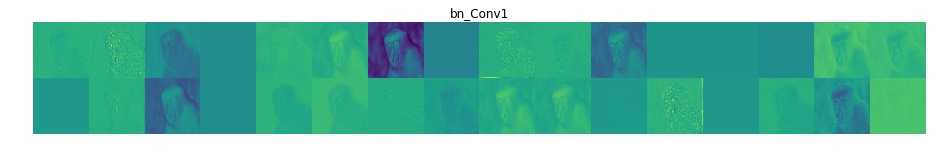

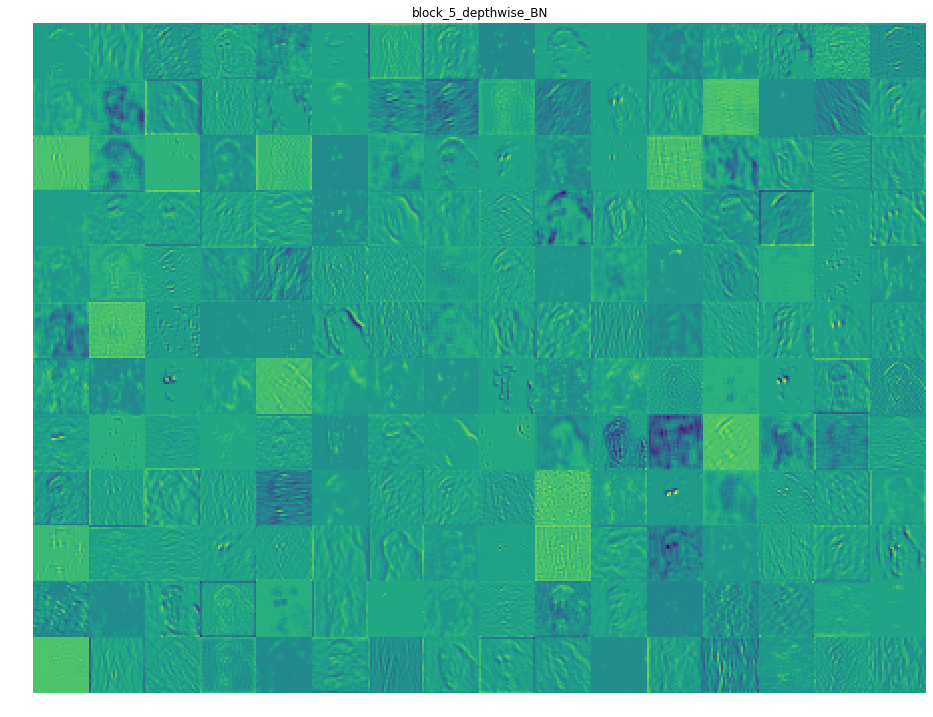

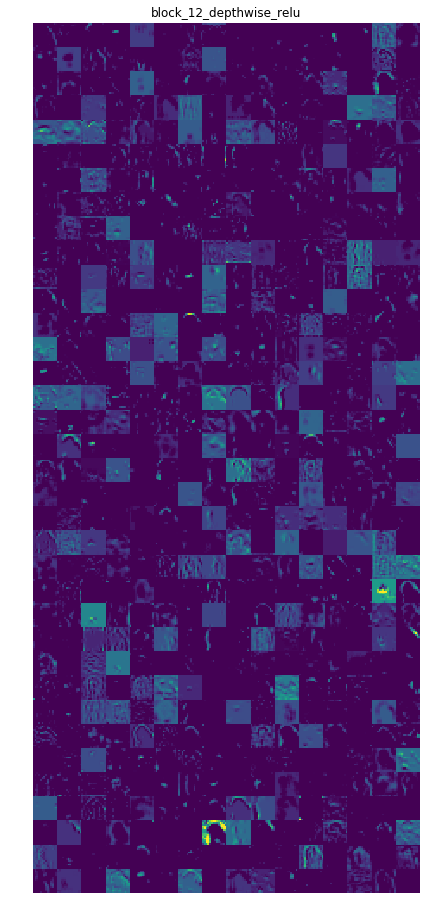

In [3]:
model = k_mobilenet_v2.MobileNetV2(weights='imagenet', include_top=True)
image_path = 'nosacz.jpg'
x = img_to_array(k_image.load_img(image_path, target_size=(224, 224)))
x = np.expand_dims(x, axis=0)
x = k_mobilenet_v2.preprocess_input(x)
show_activations(model,x,[3,50,113])

In [0]:
  def draw_rect(preprocessed_image, col, row,square_size):
    heatmap_shape = (preprocessed_image.shape[1], preprocessed_image.shape[2], 2)
    heatmap = np.zeros(heatmap_shape)
    image = preprocessed_image.copy()
    image[0, 
          row * square_size: min(row* square_size + 40, heatmap_shape[0]), 
          col * square_size: min(col * square_size + 40, heatmap_shape[1])] = [0.5, 0.5, 0.5]
    return image

In [0]:
def print_hmap(image_path):
  square_size = 10
  model = k_mobilenet_v2.MobileNetV2(weights='imagenet', include_top=True)
  
  image = k_image.load_img(image_path, target_size=(224, 224))

  img = k_image.img_to_array(image)
  img = np.expand_dims(img, axis=0)
  img = k_mobilenet_v2.preprocess_input(img)
  predictions = model.predict(img)
  guessed_class = predictions.argmax(axis=-1)
  print(k_mobilenet_v2.decode_predictions(predictions, top=1)[0])
  
  heatmap_shape = (img.shape[1], img.shape[2], 2)
  heatmap = np.zeros((img.shape[1], img.shape[2], 2))
  surce_pred = model.predict(img)
  image_class = np.argmax(surce_pred[0])
  probability = surce_pred[0, image_class]
  for row in range(math.ceil(heatmap_shape[0] / 10) - 3):
    for col in range(math.ceil(heatmap_shape[1] / 10) - 3):
      new_probability = model.predict(draw_rect(img, col, row,square_size))[0, image_class]
      for x in range(row * square_size, min(row * square_size + 40, heatmap_shape[0])):
                for y in range(col * square_size, min(col * square_size + 40, heatmap_shape[1])):
                    if heatmap[x, y, 1] == 0:
                        heatmap[x, y] = [new_probability, 1]
                    else:
                        heatmap[x, y] = [heatmap[x, y, 0] + new_probability, heatmap[x, y, 1] + 1]
        
  mean_heatmap = np.zeros((img.shape[1], img.shape[2]))                                    
  mean_heatmap[0:heatmap_shape[0], 0:heatmap_shape[1]] = heatmap[0:heatmap_shape[0], 0:heatmap_shape[1], 0] / heatmap[0:heatmap_shape[0], 0:heatmap_shape[1], 1]    

  plt.tight_layout()    
  fig, axes = plt.subplots(1, 2,  figsize=(24, 24))
  
  axes[0].matshow(mean_heatmap,cmap='jet')
  axes[0].axis('off')
  
  axes[1].imshow(image)
  axes[1].axis('off')
  
  plt.show()

[('n02489166', 'proboscis_monkey', 0.9579259)]


<Figure size 432x288 with 0 Axes>

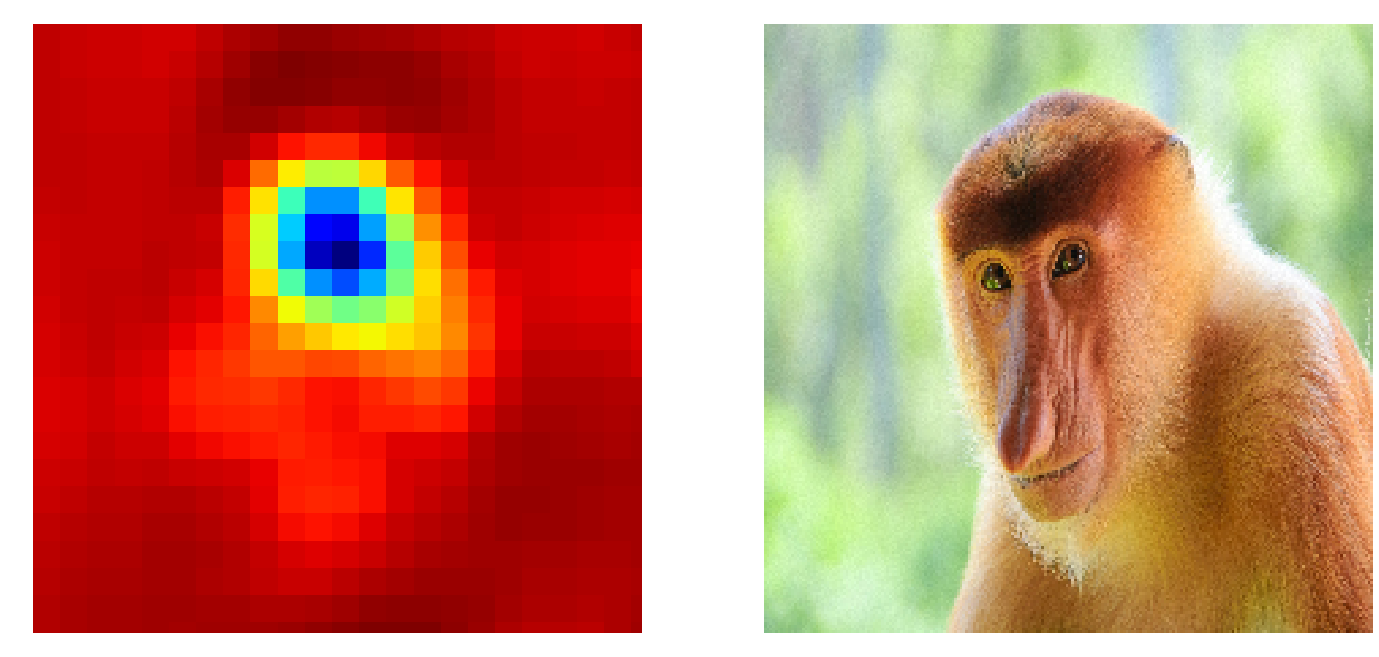

In [6]:
print_hmap('nosacz.jpg')

[('n04347754', 'submarine', 0.97588694)]


<Figure size 432x288 with 0 Axes>

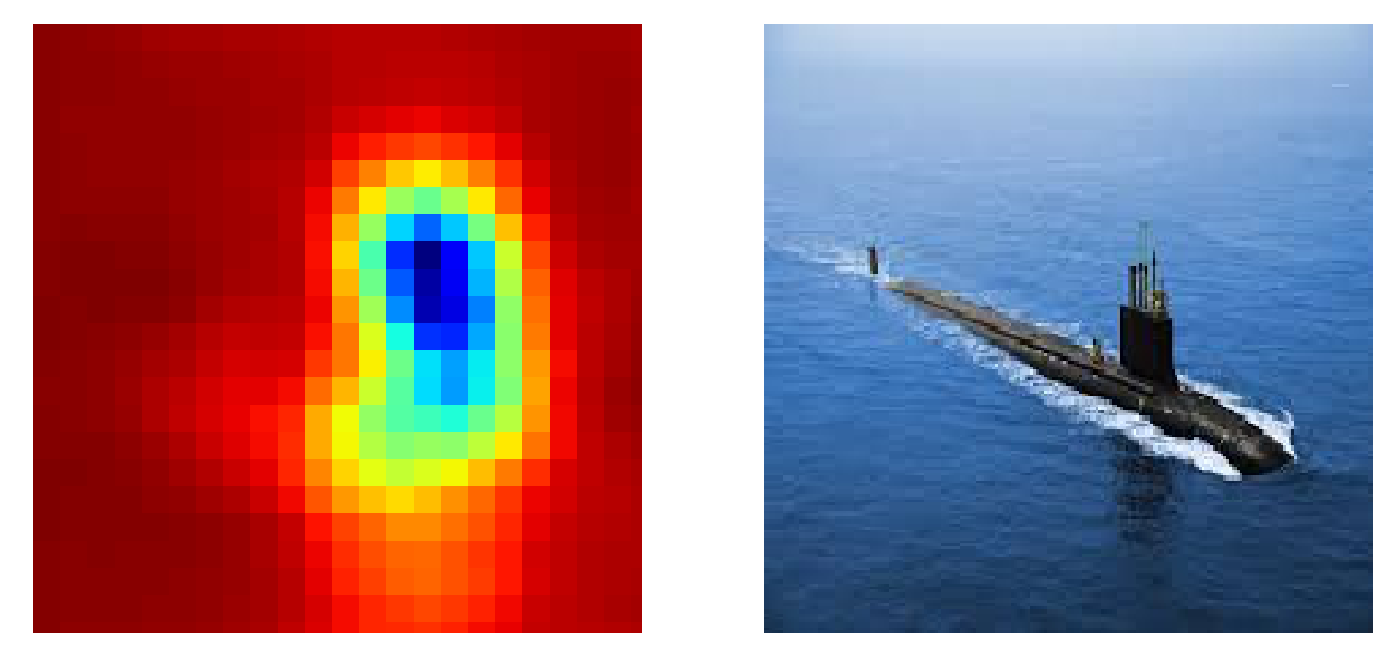

In [7]:
print_hmap('submine.jpeg')

In [0]:
from __future__ import print_function
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K

def apply_style(base_image_path,style_reference_image_path,iterations,total_variation_weight,style_weight,content_weight):
  # dimensions of the generated picture.
  width, height = load_img(base_image_path).size
  img_nrows = 400
  img_ncols = int(width * img_nrows / height)

  # util function to open, resize and format pictures into appropriate tensors


  def preprocess_image(image_path):
      img = load_img(image_path, target_size=(img_nrows, img_ncols))
      img = img_to_array(img)
      img = np.expand_dims(img, axis=0)
      img = vgg19.preprocess_input(img)
      return img

  def deprocess_image(x):
      if K.image_data_format() == 'channels_first':
          x = x.reshape((3, img_nrows, img_ncols))
          x = x.transpose((1, 2, 0))
      else:
          x = x.reshape((img_nrows, img_ncols, 3))
      # Remove zero-center by mean pixel
      x[:, :, 0] += 103.939
      x[:, :, 1] += 116.779
      x[:, :, 2] += 123.68
      # 'BGR'->'RGB'
      x = x[:, :, ::-1]
      x = np.clip(x, 0, 255).astype('uint8')
      return x

  # get tensor representations of our images
  base_image = K.variable(preprocess_image(base_image_path))
  style_reference_image = K.variable(preprocess_image(style_reference_image_path))

  # this will contain our generated image
  if K.image_data_format() == 'channels_first':
      combination_image = K.placeholder((1, 3, img_nrows, img_ncols))
  else:
      combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

  # combine the 3 images into a single Keras tensor
  input_tensor = K.concatenate([base_image,
                                style_reference_image,
                                combination_image], axis=0)

  # build the VGG19 network with our 3 images as input
  # the model will be loaded with pre-trained ImageNet weights
  model = vgg19.VGG19(input_tensor=input_tensor,
                      weights='imagenet', include_top=False)
  print('Model loaded.')

  # get the symbolic outputs of each "key" layer (we gave them unique names).
  outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

  # compute the neural style loss
  # first we need to define 4 util functions

  # the gram matrix of an image tensor (feature-wise outer product)


  def gram_matrix(x):
      assert K.ndim(x) == 3
      if K.image_data_format() == 'channels_first':
          features = K.batch_flatten(x)
      else:
          features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
      gram = K.dot(features, K.transpose(features))
      return gram

  # the "style loss" is designed to maintain
  # the style of the reference image in the generated image.
  # It is based on the gram matrices (which capture style) of
  # feature maps from the style reference image
  # and from the generated image


  def style_loss(style, combination):
      assert K.ndim(style) == 3
      assert K.ndim(combination) == 3
      S = gram_matrix(style)
      C = gram_matrix(combination)
      channels = 3
      size = img_nrows * img_ncols
      return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

  # an auxiliary loss function
  # designed to maintain the "content" of the
  # base image in the generated image


  def content_loss(base, combination):
      return K.sum(K.square(combination - base))

  # the 3rd loss function, total variation loss,
  # designed to keep the generated image locally coherent


  def total_variation_loss(x):
      assert K.ndim(x) == 4
      if K.image_data_format() == 'channels_first':
          a = K.square(
              x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
          b = K.square(
              x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
      else:
          a = K.square(
              x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
          b = K.square(
              x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
      return K.sum(K.pow(a + b, 1.25))

  loss = K.variable(0.0)

  layer_features = outputs_dict['block5_conv2']
  base_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[2, :, :, :]
  loss += content_weight * content_loss(base_image_features,
                                        combination_features)

  feature_layers = ['block1_conv1', 'block2_conv1',
                    'block3_conv1', 'block4_conv1',
                    'block5_conv1']

  for layer_name in feature_layers:
      layer_features = outputs_dict[layer_name]
      style_reference_features = layer_features[1, :, :, :]
      combination_features = layer_features[2, :, :, :]
      sl = style_loss(style_reference_features, combination_features)
      loss += (style_weight / len(feature_layers)) * sl
  loss += total_variation_weight * total_variation_loss(combination_image)

  grads = K.gradients(loss, combination_image)
  outputs = [loss]
  if isinstance(grads, (list, tuple)):
      outputs += grads
  else:
      outputs.append(grads)

  f_outputs = K.function([combination_image], outputs)
  
  f_looses = K.function([combination_image], [
      loss,
      total_variation_loss(combination_image),
      style_loss(style_reference_features, combination_features),
      content_loss(base_image_features, combination_features),
  ])


  def eval_loss_and_grads(x):
      if K.image_data_format() == 'channels_first':
          x = x.reshape((1, 3, img_nrows, img_ncols))
      else:
          x = x.reshape((1, img_nrows, img_ncols, 3))
      outs = f_outputs([x])
      loss_value = outs[0]
      if len(outs[1:]) == 1:
          grad_values = outs[1].flatten().astype('float64')
      else:
          grad_values = np.array(outs[1:]).flatten().astype('float64')
      return loss_value, grad_values

  class Evaluator(object):

      def __init__(self):
          self.loss_value = None
          self.grads_values = None

      def loss(self, x):
          assert self.loss_value is None
          loss_value, grad_values = eval_loss_and_grads(x)
          self.loss_value = loss_value
          self.grad_values = grad_values
          return self.loss_value

      def grads(self, x):
          assert self.loss_value is not None
          grad_values = np.copy(self.grad_values)
          self.loss_value = None
          self.grad_values = None
          return grad_values

  evaluator = Evaluator()
  x = preprocess_image(base_image_path)
  losses = []

  for i in range(iterations):
      print('Start of iteration', i)
      start_time = time.time()
      x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                       fprime=evaluator.grads, maxfun=20)
      print('Current loss value:', min_val)
      losses.append(f_looses([x.reshape((1, img_nrows, img_ncols, 3))]))
      img = deprocess_image(x.copy())
      plt.imshow(img)
      plt.show()
      
  return losses

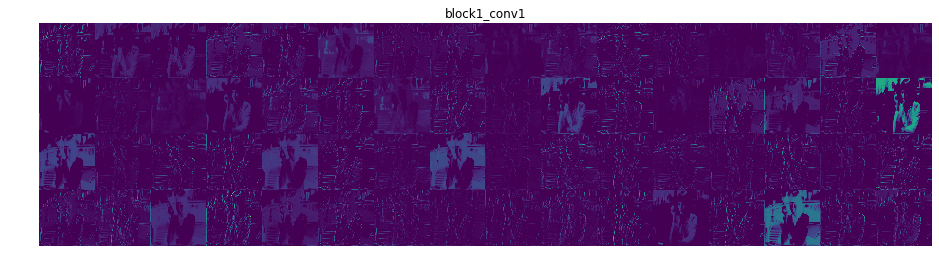

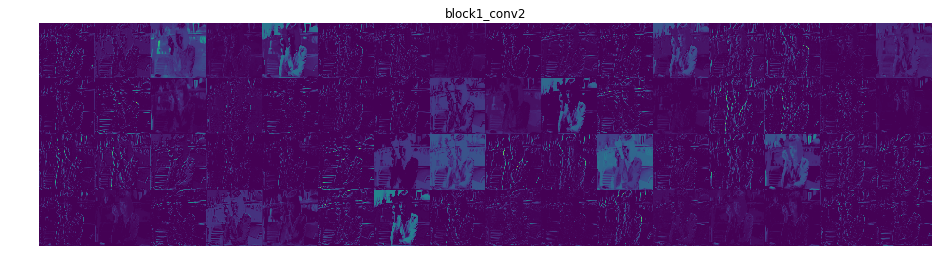

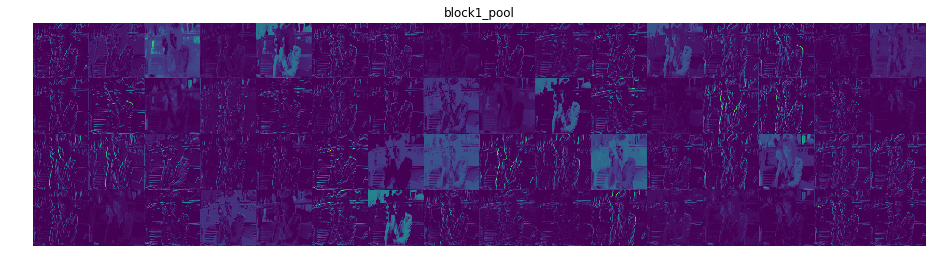

In [9]:
model = vgg19.VGG19(weights='imagenet', include_top=False)
img = load_img('MW.jpg', target_size=(300, 300))
img = img_to_array(img)
img = np.expand_dims(img, axis=0)
img = vgg19.preprocess_input(img)
show_activations(model, img, [1,2,3])

Model loaded.
Start of iteration 0
Current loss value: 9577861000.0


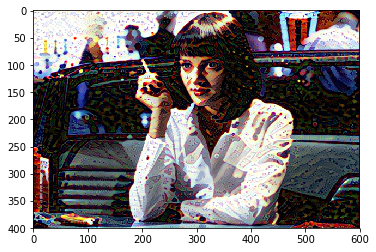

Start of iteration 1
Current loss value: 5647719000.0


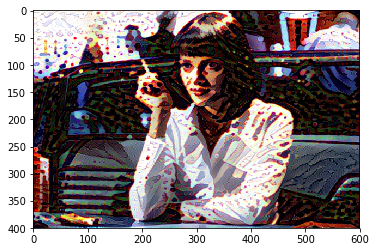

Start of iteration 2
Current loss value: 4852737500.0


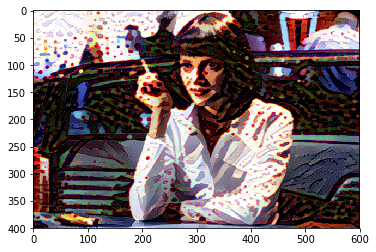

Start of iteration 3
Current loss value: 4445821000.0


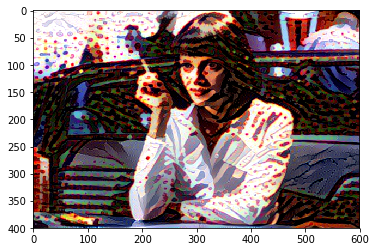

Start of iteration 4
Current loss value: 4209364000.0


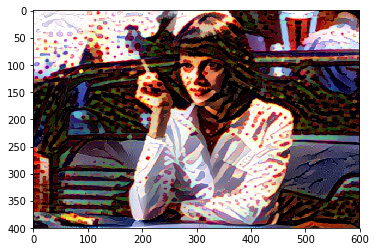

Start of iteration 5
Current loss value: 4057908000.0


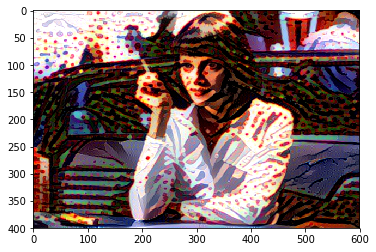

Start of iteration 6
Current loss value: 3950128600.0


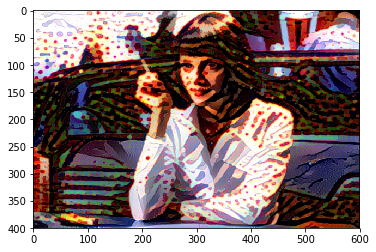

Start of iteration 7
Current loss value: 3865773300.0


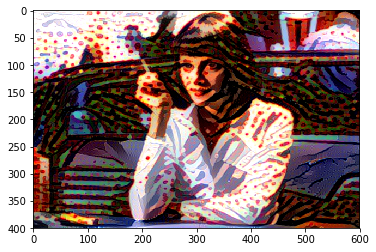

Start of iteration 8
Current loss value: 3799794700.0


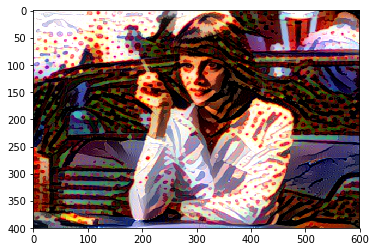

Start of iteration 9
Current loss value: 3742895600.0


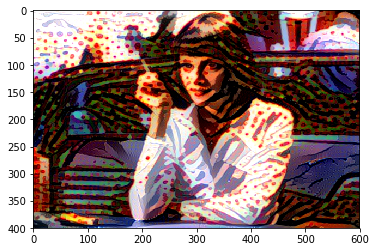

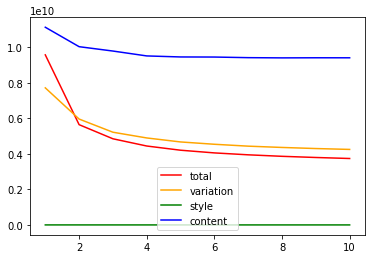

In [10]:
base_image_path = 'MW.jpg'
style_reference_image_path = 'style2.jpg'
iterations = 10
total_variation_weight = 0.5
style_weight = 0.1
content_weight = 0.2
looses = apply_style(base_image_path,style_reference_image_path,iterations,total_variation_weight,style_weight,content_weight)

total_losses = [looses[i][0] for i in range(len(looses))]
variation_losses = [looses[i][1] for i in range(len(looses))]
style_losses = [looses[i][2] for i in range(len(looses))]
content_losses = [looses[i][3] for i in range(len(looses))]

plt.plot(range(1, len(looses) + 1), total_losses, color='red', label='total')
plt.plot(range(1, len(looses) + 1), variation_losses, color='orange', label='variation')
plt.plot(range(1, len(looses) + 1), style_losses, color='green', label='style')
plt.plot(range(1, len(looses) + 1), content_losses, color='blue', label='content')
plt.legend()

plt.show()

Model loaded.
Start of iteration 0
Current loss value: 378805680000.0


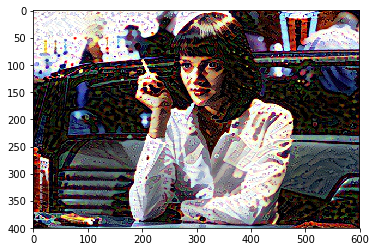

Start of iteration 1
Current loss value: 141898920000.0


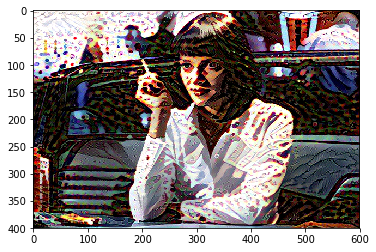

Start of iteration 2
Current loss value: 83170550000.0


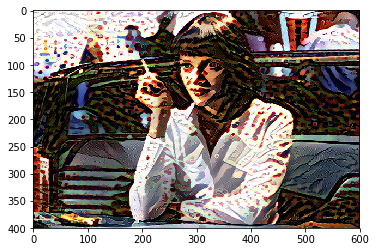

Start of iteration 3
Current loss value: 62038303000.0


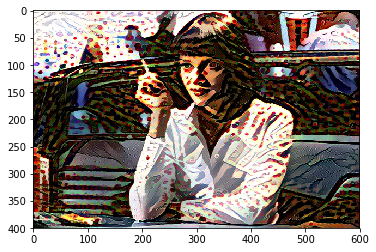

Start of iteration 4
Current loss value: 50352263000.0


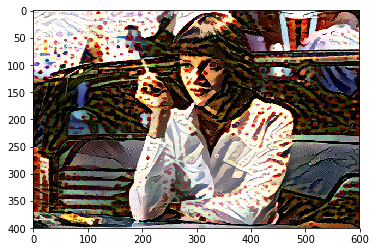

Start of iteration 5
Current loss value: 43263324000.0


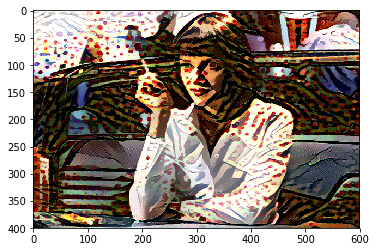

Start of iteration 6
Current loss value: 37778250000.0


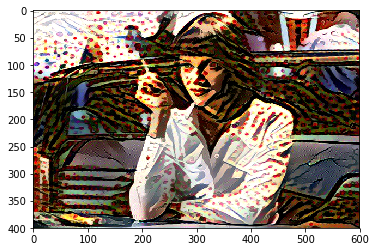

Start of iteration 7
Current loss value: 33724865000.0


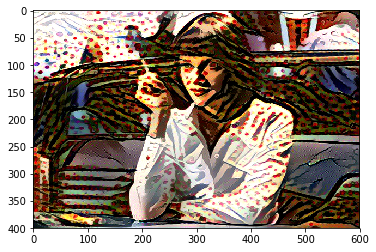

Start of iteration 8
Current loss value: 30931378000.0


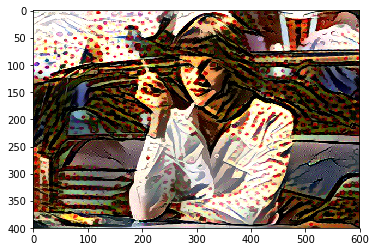

Start of iteration 9
Current loss value: 28732017000.0


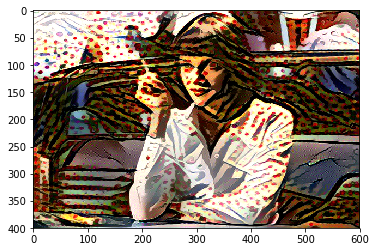

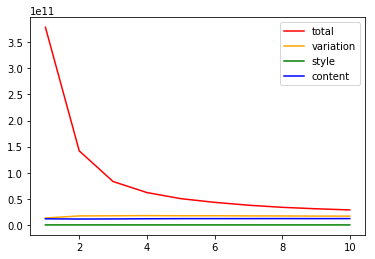

In [11]:
base_image_path = 'MW.jpg'
style_reference_image_path = 'style2.jpg'
iterations = 10
total_variation_weight = 0.5
style_weight = 10
content_weight = 0.2
looses = apply_style(base_image_path,style_reference_image_path,iterations,total_variation_weight,style_weight,content_weight)

total_losses = [looses[i][0] for i in range(len(looses))]
variation_losses = [looses[i][1] for i in range(len(looses))]
style_losses = [looses[i][2] for i in range(len(looses))]
content_losses = [looses[i][3] for i in range(len(looses))]

plt.plot(range(1, len(looses) + 1), total_losses, color='red', label='total')
plt.plot(range(1, len(looses) + 1), variation_losses, color='orange', label='variation')
plt.plot(range(1, len(looses) + 1), style_losses, color='green', label='style')
plt.plot(range(1, len(looses) + 1), content_losses, color='blue', label='content')
plt.legend()

plt.show()

In [0]:
from __future__ import print_function
from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K

    

def disguise(base_image_path,iterations,desired_class):
  width, height = load_img(base_image_path).size
  img_nrows = 224
  img_ncols = 224

  def preprocess_image(image_path):
      img = load_img(image_path, target_size=(img_nrows, img_ncols))
      img = img_to_array(img)
      img = np.expand_dims(img, axis=0)
      img = vgg19.preprocess_input(img)
      return img
    
  def preprocess(img):
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

  def deprocess_image(x):
      if K.image_data_format() == 'channels_first':
          x = x.reshape((3, img_nrows, img_ncols))
          x = x.transpose((1, 2, 0))
      else:
          x = x.reshape((img_nrows, img_ncols, 3))
      # Remove zero-center by mean pixel
      x[:, :, 0] += 103.939
      x[:, :, 1] += 116.779
      x[:, :, 2] += 123.68
      # 'BGR'->'RGB'
      x = x[:, :, ::-1]
      x = np.clip(x, 0, 255).astype('uint8')
      return x

  base_image = preprocess_image(base_image_path)

  model = vgg19.VGG19(weights='imagenet', include_top=True)
  print('Model loaded.')
  print(vgg19.decode_predictions(model.predict(base_image), top=5), '\n')

  outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

  loss = -K.log(model.output[0, desired_class])
  # get the gradients of the generated image wrt the loss
  grads = K.gradients(loss, model.input)

  outputs = [loss]
  if isinstance(grads, (list, tuple)):
      outputs += grads
  else:
      outputs.append(grads)

  f_outputs = K.function([model.input], outputs)

  def eval_loss_and_grads(x):
      if K.image_data_format() == 'channels_first':
          x = x.reshape((1, 3, img_nrows, img_ncols))
      else:
          x = x.reshape((1, img_nrows, img_ncols, 3))
      outs = f_outputs([x])
      loss_value = outs[0]
      if len(outs[1:]) == 1:
          grad_values = outs[1].flatten().astype('float64')
      else:
          grad_values = np.array(outs[1:]).flatten().astype('float64')
      return loss_value, grad_values

  class Evaluator(object):

      def __init__(self):
          self.loss_value = None
          self.grads_values = None

      def loss(self, x):
          assert self.loss_value is None
          loss_value, grad_values = eval_loss_and_grads(x)
          self.loss_value = loss_value
          self.grad_values = grad_values
          return self.loss_value

      def grads(self, x):
          assert self.loss_value is not None
          grad_values = np.copy(self.grad_values)
          self.loss_value = None
          self.grad_values = None
          return grad_values

  evaluator = Evaluator()
  x = preprocess_image(base_image_path)

  for i in range(iterations):
      print('Start of iteration', i)
      start_time = time.time()
      x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                       fprime=evaluator.grads, maxfun=20)
      print('Current loss value:', min_val)
      
      img = deprocess_image(x.copy())
    
      plt.imshow(img)
      plt.show()
      plt.axis('off')
      end_time = time.time()
      print(vgg19.decode_predictions(model.predict(preprocess(img)), top=5), '\n')
      print('Iteration %d completed in %ds' % (i, end_time - start_time))

Model loaded.
[[('n02113023', 'Pembroke', 0.7956821), ('n02113186', 'Cardigan', 0.19982195), ('n02106030', 'collie', 0.0014504797), ('n02110806', 'basenji', 0.0010815233), ('n02105855', 'Shetland_sheepdog', 0.001068702)]] 

Start of iteration 0
Current loss value: 0.012953912


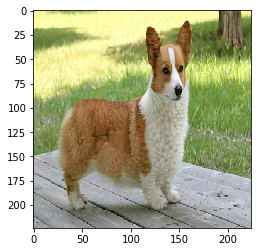

[[('n02113799', 'standard_poodle', 0.98644364), ('n02113712', 'miniature_poodle', 0.005229183), ('n02113624', 'toy_poodle', 0.0020930131), ('n02095314', 'wire-haired_fox_terrier', 0.0014205349), ('n02437616', 'llama', 0.0012603462)]] 

Iteration 0 completed in 2s
Start of iteration 1
Current loss value: 0.012953912


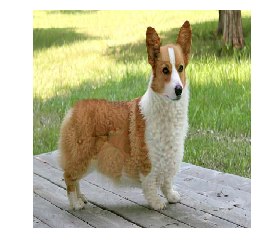

[[('n02113799', 'standard_poodle', 0.98644364), ('n02113712', 'miniature_poodle', 0.005229183), ('n02113624', 'toy_poodle', 0.0020930131), ('n02095314', 'wire-haired_fox_terrier', 0.0014205349), ('n02437616', 'llama', 0.0012603462)]] 

Iteration 1 completed in 0s
Start of iteration 2
Current loss value: 0.012953912


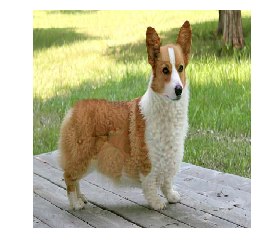

[[('n02113799', 'standard_poodle', 0.98644364), ('n02113712', 'miniature_poodle', 0.005229183), ('n02113624', 'toy_poodle', 0.0020930131), ('n02095314', 'wire-haired_fox_terrier', 0.0014205349), ('n02437616', 'llama', 0.0012603462)]] 

Iteration 2 completed in 0s
Start of iteration 3
Current loss value: 0.012953912


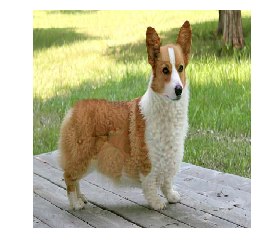

[[('n02113799', 'standard_poodle', 0.98644364), ('n02113712', 'miniature_poodle', 0.005229183), ('n02113624', 'toy_poodle', 0.0020930131), ('n02095314', 'wire-haired_fox_terrier', 0.0014205349), ('n02437616', 'llama', 0.0012603462)]] 

Iteration 3 completed in 0s
Start of iteration 4
Current loss value: 0.012953912


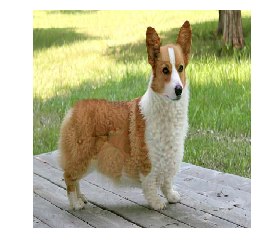

[[('n02113799', 'standard_poodle', 0.98644364), ('n02113712', 'miniature_poodle', 0.005229183), ('n02113624', 'toy_poodle', 0.0020930131), ('n02095314', 'wire-haired_fox_terrier', 0.0014205349), ('n02437616', 'llama', 0.0012603462)]] 

Iteration 4 completed in 0s
Start of iteration 5
Current loss value: 0.012953912


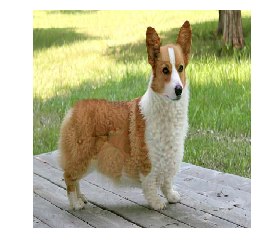

[[('n02113799', 'standard_poodle', 0.98644364), ('n02113712', 'miniature_poodle', 0.005229183), ('n02113624', 'toy_poodle', 0.0020930131), ('n02095314', 'wire-haired_fox_terrier', 0.0014205349), ('n02437616', 'llama', 0.0012603462)]] 

Iteration 5 completed in 0s
Start of iteration 6
Current loss value: 0.012953912


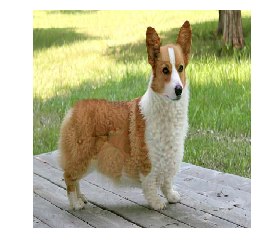

[[('n02113799', 'standard_poodle', 0.98644364), ('n02113712', 'miniature_poodle', 0.005229183), ('n02113624', 'toy_poodle', 0.0020930131), ('n02095314', 'wire-haired_fox_terrier', 0.0014205349), ('n02437616', 'llama', 0.0012603462)]] 

Iteration 6 completed in 0s
Start of iteration 7
Current loss value: 0.012953912


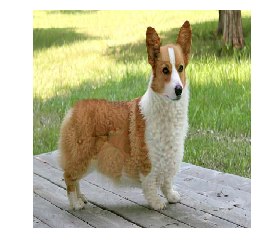

[[('n02113799', 'standard_poodle', 0.98644364), ('n02113712', 'miniature_poodle', 0.005229183), ('n02113624', 'toy_poodle', 0.0020930131), ('n02095314', 'wire-haired_fox_terrier', 0.0014205349), ('n02437616', 'llama', 0.0012603462)]] 

Iteration 7 completed in 0s
Start of iteration 8
Current loss value: 0.012953912


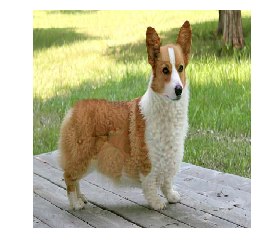

[[('n02113799', 'standard_poodle', 0.98644364), ('n02113712', 'miniature_poodle', 0.005229183), ('n02113624', 'toy_poodle', 0.0020930131), ('n02095314', 'wire-haired_fox_terrier', 0.0014205349), ('n02437616', 'llama', 0.0012603462)]] 

Iteration 8 completed in 0s
Start of iteration 9
Current loss value: 0.012953912


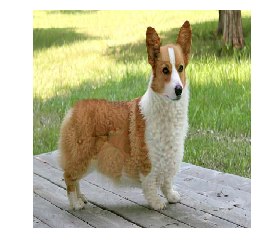

[[('n02113799', 'standard_poodle', 0.98644364), ('n02113712', 'miniature_poodle', 0.005229183), ('n02113624', 'toy_poodle', 0.0020930131), ('n02095314', 'wire-haired_fox_terrier', 0.0014205349), ('n02437616', 'llama', 0.0012603462)]] 

Iteration 9 completed in 0s


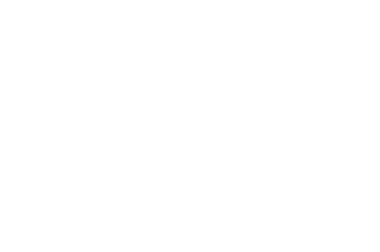

In [13]:
disguise('corgie.jpg',10,267)